# Output EDA
   

## utterance 길이는 비슷한데, output의 길이가 차이나는 이유가 무엇인가?

   - output의 길이 결정에 끼치는 중요한 특징 찾기

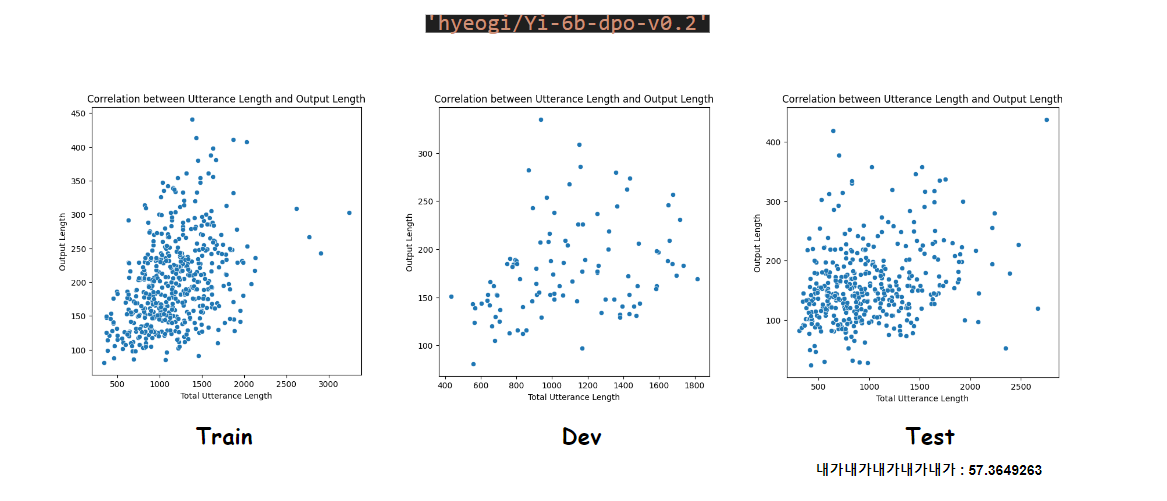
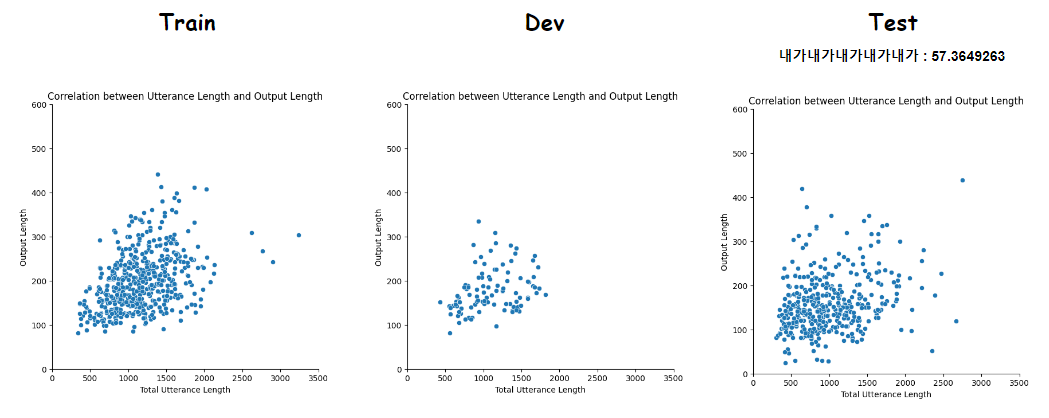

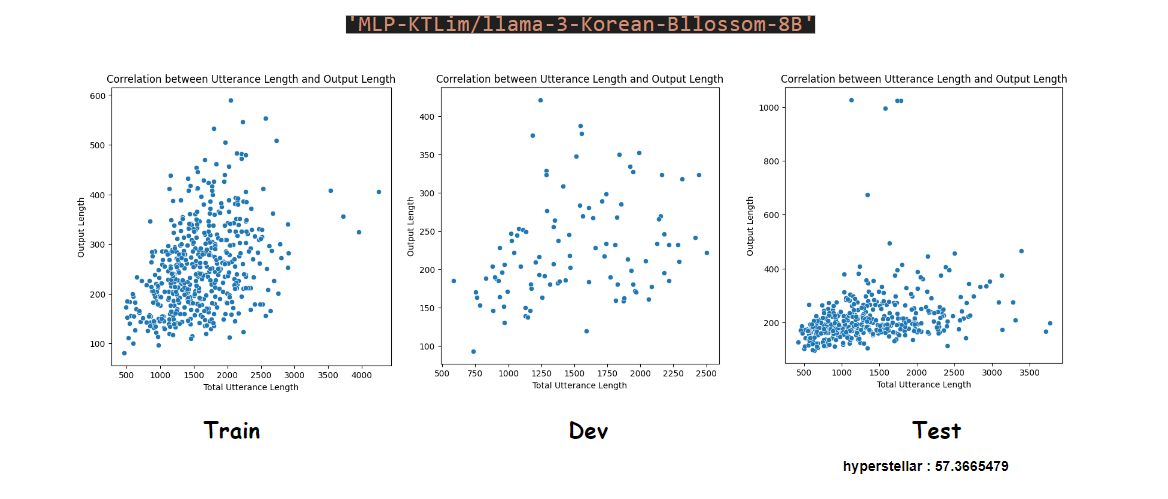
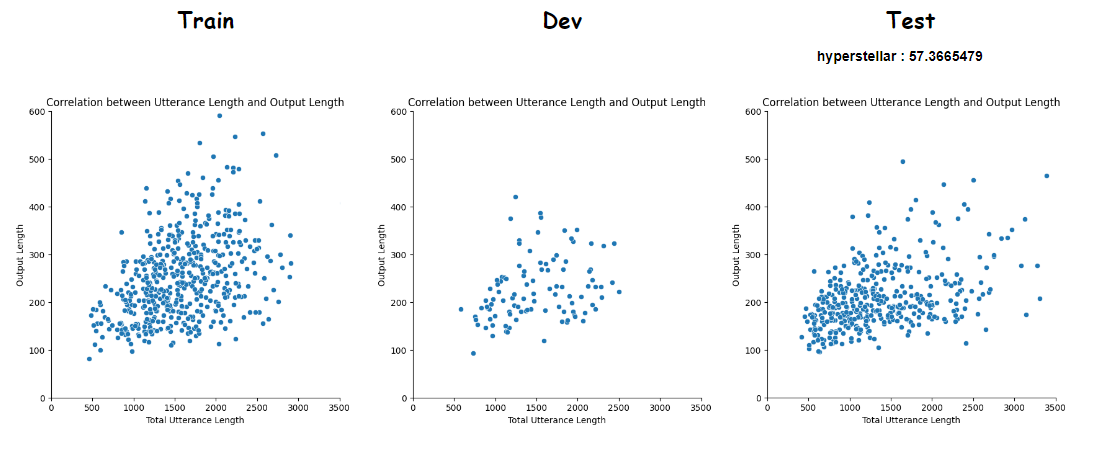

In [17]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from transformers import AutoTokenizer

In [2]:
def make_dataframe(path: str) -> pd.DataFrame:
    """
    Read a json file and return a pandas DataFrame.

    Parameters:
    path (str): Path to the json file.

    Returns:
    pd.DataFrame: DataFrame of the json file.
    """
    # Read the json file
    with open(path, 'r') as file:
        data = json.load(file)

    # Create a DataFrame
    # columns = ['id', 'conversation', 'subject_keyword', 'output']
    df = pd.DataFrame(data)
    df['conversation'] = df['input'].apply(lambda x: x['conversation'])
    df['subject_keyword'] = df['input'].apply(lambda x: x['subject_keyword'])

    # Drop the 'input' column
    df.drop('input', axis=1, inplace=True)

    # Speakers in the conversation
    df['speakers'] = df['conversation'].apply(lambda turns: list(set(turn['speaker'] for turn in turns)))

    # Reorder the columns
    df = df[['id', 'conversation', 'subject_keyword', 'speakers', 'output']]

    return df

In [3]:
train_df = make_dataframe('../resource/data/일상대화요약_train.json')
dev_df = make_dataframe('../resource/data/일상대화요약_dev.json')
test_df = make_dataframe('../resource/data/일상대화요약_test.json')

In [4]:
train_df

,id,conversation,subject_keyword,speakers,output
0,nikluge-2024-일상 대화 요약-train-000001,"[{'speaker': 'SD2000001', 'utterance': '저는 여행 ...",[해외여행],"[SD2000002, SD2000001]",이 대화에서 화자들은 좋았던 여행지와 기억나는 주요 명소에 대해 이야기했습니다. S...
1,nikluge-2024-일상 대화 요약-train-000002,"[{'speaker': 'SD2000002', 'utterance': '여행 다닐 ...","[여행 스타일, 숙소, 음식]","[SD2000002, SD2000001]","이 대화에서 화자들은 쇼핑하기, 숙소, 음식 등 각자 선호하는 여행 스타일에 대해 ..."
2,nikluge-2024-일상 대화 요약-train-000003,"[{'speaker': 'SD2000001', 'utterance': '그래서 한번...","[여행지, 일화]","[SD2000002, SD2000001]",이 대화에서 화자들은 기억에 남는 여행지와 일화에 대해 이야기했습니다. SD2000...
3,nikluge-2024-일상 대화 요약-train-000004,"[{'speaker': 'SD2000005', 'utterance': 'name1 ...","[음식, 선호, 길거리 음식, 싫어하는 음식]","[SD2000005, SD2000006]",두 화자는 이 대화에서 좋아하는 음식과 싫어하는 음식에 대해 말했습니다. SD200...
4,nikluge-2024-일상 대화 요약-train-000005,"[{'speaker': 'SD2000006', 'utterance': '그러면 na...","[다이어트 식품, 마실것]","[SD2000005, SD2000006]",두 화자는 이 대화에서 다이어트 식품과 좋아하는 음료에 대해 이야기했습니다. SD2...
...,...,...,...,...,...
501,nikluge-2024-일상 대화 요약-train-000502,"[{'speaker': 'SD2100596', 'utterance': '그 comp...",[company-name5],"[SD2100596, SD2100595]",두 화자는 이 대화에서 유명 유튜버의 식당 추천과 음식 장사의 성공 요인에 대해서 ...
502,nikluge-2024-일상 대화 요약-train-000503,"[{'speaker': 'SD2100598', 'utterance': '나 이번 달...",[행복 주택],"[SD2100597, SD2100598]",이 대화에서 화자들은 주택 마련 방법과 고충에 대해서 이야기했습니다. SD21005...
503,nikluge-2024-일상 대화 요약-train-000504,"[{'speaker': 'SD2100598', 'utterance': '저는 지금 ...",[수익],"[SD2100597, SD2100598]",이 대화에서 화자들은 현재 소득에서 수익 창출 방법에 대해 이야기 했습니다. SD2...
504,nikluge-2024-일상 대화 요약-train-000505,"[{'speaker': 'SD2100599', 'utterance': '동네에 맛있...",[점심],"[SD2100600, SD2100599]",이 대화에서 화자들은 좋아하는 치킨 브랜드와 어제 저녁 먹은 음식과 점심으로 먹은 ...


In [5]:
tokenizer = AutoTokenizer.from_pretrained('hyeogi/Yi-6b-dpo-v0.2')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### total utterance token 개수가 1400~1500 사이 샘플중에서
    - output이 작은 하위 샘플 10개와, output이 큰 상위 샘플 10개 간의 특징 차이 비교

In [6]:
def correlation_between_utterance_length_and_output_length(df: pd.DataFrame, tokenizer, utterance_length_range: tuple = None) -> None:
    """
    Plot the correlation between the utterance length and the output length.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.
    tokenizer: Tokenizer from Hugging Face Transformers.
    """
    # Copy the DataFrame
    df = deepcopy(df)

    # Calculate the length of the utterance and the output
    total_utterance_length = df['conversation'].apply(lambda x: sum(len(tokenizer.encode(turn['utterance'], add_special_tokens=False)) for turn in x))
    output_length = df['output'].apply(lambda x: len(tokenizer.encode(x)))

    # Choose different color in the utterance_length_range
    
    if utterance_length_range:
        df['color'] = total_utterance_length.apply(lambda x: 'r' if utterance_length_range[0] <= x <= utterance_length_range[1] else 'b')


    # Plot the correlation
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=total_utterance_length, y=output_length, hue=df['color'] if utterance_length_range else None)
    plt.xlim(0, 3500)
    plt.ylim(0, 600)

    sns.despine()
    plt.xlabel('Total Utterance Length')
    plt.ylabel('Output Length')
    plt.title('Correlation between Utterance Length and Output Length')
    plt.show()

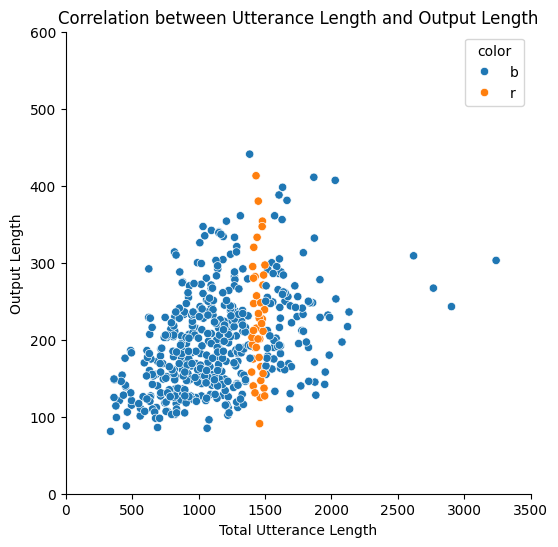

In [23]:
correlation_between_utterance_length_and_output_length(train_df, tokenizer, utterance_length_range=(1400, 1500))

In [7]:
def extract_two_type_output_length_samples(df: pd.DataFrame, tokenizer, utterance_length_range: tuple) -> pd.DataFrame:
    """
    Extract samples of two types of output lengths.

    Parameters:
    df (pd.DataFrame): DataFrame of the dataset.

    Returns:
    pd.DataFrame: DataFrame of the samples of two types of output lengths.
    """

    def check_valid_output_length(conv: list) -> bool:
        total_length = sum(len(tokenizer.encode(turn['utterance'], add_special_tokens=False)) for turn in conv)
        return utterance_length_range[0] <= total_length <= utterance_length_range[1]
    
    # Tokenize the total utterance and extract samples that the total utterance length is from 1250 to 1500
    total_utterance_length = df['conversation'].apply(check_valid_output_length)
    sampled_df = df[total_utterance_length].copy()

    print("The number of sampled data: ", len(sampled_df))

    # Filter bottom 10 and top 10 of the output length
    output_length = sampled_df['output'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
    
    # sort by output length
    sampled_df['output_length'] = output_length
    sampled_df.sort_values('output_length', inplace=True)

    # Extract the bottom 10 and top 10 of the output length
    bottom_10 = sampled_df.head(10)
    top_10 = sampled_df.tail(10)

    return bottom_10, top_10, sampled_df

In [8]:
bottom_10, top_10, sampled_df = extract_two_type_output_length_samples(train_df, tokenizer, utterance_length_range=(1400, 1500))

The number of sampled data:  42


In [45]:
bottom_10

,id,conversation,subject_keyword,speakers,output,output_length
26,nikluge-2024-일상 대화 요약-train-000027,"[{'speaker': 'SD2000870', 'utterance': '여자가 결혼...",[자식],"[SD2000869, SD2000870]",두 화자는 이 대화에서 자식을 낳는 것에 대해 말했습니다. SD2000869는 본인...,90
70,nikluge-2024-일상 대화 요약-train-000071,"[{'speaker': 'SD2000936', 'utterance': '그 외에 국...",[국내 여행],"[SD2000937, SD2000936]",두 화자는 이 대화에서 국내 여행지에 대해 이야기했습니다. SD2000936은 전라...,124
437,nikluge-2024-일상 대화 요약-train-000438,"[{'speaker': 'SD2100543', 'utterance': '국내에서 제...",[여행지],"[SD2100543, SD2100544]",이 대화에서 두 화자는 자신들이 가고 싶거나 추천하는 여행지에 대해 이야기했습니다....,126
215,nikluge-2024-일상 대화 요약-train-000216,"[{'speaker': 'SD2002196', 'utterance': '애들이 대학...",[요리],"[SD2002195, SD2002196]",SD2002195와 SD2002196은 가족들의 식사에 대해 대화를 나눴습니다. S...,130
291,nikluge-2024-일상 대화 요약-train-000292,"[{'speaker': 'SD2002551', 'utterance': '이렇게 생각...",[사회생활],"[SD2002550, SD2002551]",두 사람은 사회생활에 관한 대화를 나눴습니다. SD2002551은 교수님의 지시에는...,136
57,nikluge-2024-일상 대화 요약-train-000058,"[{'speaker': 'SD2000906', 'utterance': '저 혹시 여...",[여행],"[SD2000907, SD2000906]",두 화자는 이 대화에서 인상 깊었던 여행에 대해 말했습니다. SD2000906은 동...,139
159,nikluge-2024-일상 대화 요약-train-000160,"[{'speaker': 'SD2001259', 'utterance': '현모양처가 ...",[꿈],"[SD2001258, SD2001259]",두 화자는 이 대화에서 본인의 꿈에 대해 말했습니다. SD2001259는 임신 출산...,146
287,nikluge-2024-일상 대화 요약-train-000288,"[{'speaker': 'SD2002510', 'utterance': '내 성격 장...",[성격],"[SD2002510, SD2002511]",두 사람은 성격의 장단점에 관한 대화를 나눴습니다. SD2002510의 좋은 점은 ...,155
120,nikluge-2024-일상 대화 요약-train-000121,"[{'speaker': 'SD2001104', 'utterance': '성격은 주위...",[성격],"[SD2001106, SD2001104]",두 화자는 이 대화에서 성격에 대해 말했습니다. SD2001104는 가족 외의 타인...,157
131,nikluge-2024-일상 대화 요약-train-000132,"[{'speaker': 'SD2001148', 'utterance': '최근에 영화...",[장르],"[SD2001148, SD2001149]",두 화자는 이 대화에서 선호하는 영화 장르에 대해 말했습니다. SD2001148은 ...,157


In [30]:
top_10

,id,conversation,subject_keyword,speakers,output,output_length
303,nikluge-2024-일상 대화 요약-train-000304,"[{'speaker': 'SD2100446', 'utterance': '근데 내가 ...","[대학, 휴학, 사이버 강의]","[SD2100445, SD2100446]",이 대화에서 화자들은 대학에 대해 이야기했습니다. SD2100446은 대학은 자기 ...,281
450,nikluge-2024-일상 대화 요약-train-000451,"[{'speaker': 'SD2100560', 'utterance': '언니 저번에...",[시험],"[SD2100560, SD2100559]",두 화자는 대화에서 시험과 면접에 관해 이야기하였습니다. SD2100560은 서울교...,283
391,nikluge-2024-일상 대화 요약-train-000392,"[{'speaker': 'SD2100498', 'utterance': '음 그러면은...",[운동],"[SD2100497, SD2100498]",두 사람은 운동과 건강에 대해 이야기했습니다. 화자 SD2100498은 주 5회 헬...,294
299,nikluge-2024-일상 대화 요약-train-000300,"[{'speaker': 'SD2100017', 'utterance': '그래서 기본...",[다이어트],"[SD2100017, SD2100018]",이 대화에서 화자들은 다이어트와 영양제에 대해서 이야기했습니다. SD2100017은...,296
413,nikluge-2024-일상 대화 요약-train-000414,"[{'speaker': 'SD2100517', 'utterance': '어저께 그 ...",[음식],"[SD2100517, SD2100518]",이 대화에서 화자 SD2100517과 SD2100518은 음식에 대해 이야기했습니다...,319
138,nikluge-2024-일상 대화 요약-train-000139,"[{'speaker': 'SD2001183', 'utterance': '가족들하고의...",[가족],"[SD2001184, SD2001183]",두 화자는 이 대화에서 가족 관계의 어려움과 만남에 대해 말했습니다. SD20011...,332
500,nikluge-2024-일상 대화 요약-train-000501,"[{'speaker': 'SD2100595', 'utterance': '뭐 최근에 ...",[음식],"[SD2100596, SD2100595]",두 화자는 이 대화에서 선호하는 음식점과 음식에 대해 말했습니다. SD2100595...,346
312,nikluge-2024-일상 대화 요약-train-000313,"[{'speaker': 'SD2100459', 'utterance': '요새 티브이...",[경연 프로그램],"[SD2100459, SD2100460]",이 대화에서 화자들은 음악 경연 프로그램에 대해서 이야기했습니다. SD2100459...,353
309,nikluge-2024-일상 대화 요약-train-000310,"[{'speaker': 'SD2100456', 'utterance': '혹시 내가 ...",[요리],"[SD2100456, SD2100455]",이 대화에서 화자들은 건강 음식과 요리법에 대해서 이야기했습니다. SD2100455...,379
306,nikluge-2024-일상 대화 요약-train-000307,"[{'speaker': 'SD2100454', 'utterance': '예전에 우리...",[강아지],"[SD2100453, SD2100454]","이 대화에서 화자들은 강아지, 고양이, 앵무새에 대해서 이야기했습니다. SD2100...",412


## 대화 내용 속 어떤 내용들이 output 에 요약되는가?

- keyword와 연관되어 있지 않은 내용도 요약되는가?


In [12]:
import re
stopwords_pattern = [r'name[0-9]\S*', r'\w~', r'\b으\b', r'\b그\b', r'\b뭐\b', r'\b어\b',  r'\b인제\b', r'\b이제\b', r'\b막\b', r'\b아\b', r'\b음\b', r'\b읍\b', r'\b오\b', r'\b으\b']

def remove_stopwords(text):
    for pattern in stopwords_pattern:
        text = re.sub(pattern, '', text)
    
    # 두 번 이상 반복되는 경우
    text = re.sub(r'\b(\w)\s+\1\b', r'\1', text)

    # 공백 두 번 이상 연속 -> 1개로
    text = re.sub(r'\s{2,}', ' ', text)
    
    return text

In [15]:
def manual_analysis(df, idx):

    sampele = df.iloc[idx]

    print("Keywords : ", sampele['subject_keyword'])

    print("[Conversation] \n ")
    for idx, turn in enumerate(sampele['conversation']):
        if idx == 0:
            print("speaker : ", turn['speaker'])
        elif sampele['conversation'][idx-1]['speaker'] != turn['speaker']:
            print("\n\n")
            print("speaker : ", turn['speaker'])

        print(*turn['utterance'].split('.'), sep='\n')
        # print([remove_stopwords(utter) for utter in turn['utterance'].split('.')], sep='\n')
        

In [22]:
manual_analysis(top_10, 8)

Keywords :  ['요리']
[Conversation] 
 
speaker :  SD2100456
혹시 내가 요즘 유튜브를 통해서 본 건데 아침 사과가 좋다 그러잖아요
 그래서 그런데 그 사과를 먹고 녹차를 같이 마셔도 마시면 그렇게 좋대요

요즘 알은 정보에요
 사과 하 사과를 먹고 나서 녹차를 한 잔



speaker :  SD2100455
아 그거는 뭐 뭐 아침 아침 그 뭐 저녁도 뭐 이런 거 없이 그냥 무조건 좋은 건가 봐요?



speaker :  SD2100456
보통 아침에 먹으라고 저녁에는 해가 되고 아침 사과는 뭐라고 좋 좋다고 근데 아무튼 아침에 먹건 뭐 점심에 먹건 사과 먹고 녹차를 곁들이면 심장에도 좋고 암 예방 효과에도 좋고 그런 정보를 들었어요

그래서 실천은 아직 안 해봤는데 사과만 먹고 녹차까진 아직 안 먹어 봤는데 아 그 그 그래야 되겠구나
 그런 정보를 또 요즘 많이 또 유튜브를 통해서 알게 되니까 좋더라고요?



speaker :  SD2100455
어 그 좋은 정보 같아요
 그런 거 좋은 거 알고 있으면은 당장 실천은 안 하더라도 이제 기억 속에 있으니까 어 더 그런 쪽으로 더 그 실천을 할 거 같긴 해요
 커피보다는 이제 녹차로



speaker :  SD2100456
그리고 이거는 음 음식 이야긴지 건강 이야기인지
모르겠지만 사과를 또 구워 먹으면 올리브유에다가 구워 먹으면 장 청소를 다 해준대요

그 대신 그렇게 구워 먹는 사과에는 장 청소해 주는 그런 기능은 엄청 늘어나는데 이 비타민은 줄어들겠죠
 그러니까는 그냥 사과 그냥도 먹고 또 장이 안 좋을 때는 일주일에 두 번 정도만 그렇게 먹어도 좋다 그러더라고요
 일주일에 두 번 정도만 올리브유 한 두 스푼 정도 프라이팬에 달군 다음에 사과를 구워 먹으면 장 청소를 깨끗이 해준다 그러더라고




speaker :  SD2100455
아 그러면은 그 변비 있는 사람한테 좋을 거 같은데요? 어 요새 저기 그 젊은 사람들이나 뭐 나이 먹은 분들 다 그 변비들 때

In [23]:
print("Output : ", top_10.iloc[8]['output'])

Output :  이 대화에서 화자들은 건강 음식과 요리법에 대해서 이야기했습니다. SD2100455는 레시피를 보면서 하는 게 번잡스럽고 피곤할 거 같다며 맛이 있으나 없으나 자신의 손맛대로 해 먹는데 맛있다고 말했습니다. 또 음식이 맛있으려면 레시피도 중요하지만 재료가 신선하면 2, 30프로 맛이 더 있어지는 거 같다고 말했습니다. 예전에 김밥을 쌀 때 함량 생각 안 하고 사서 했을 때와 좋은 함량을 썼을 때와 맛이 달랐다고 말했습니다. 그래서 지금은 함량을 생각해서 일부러 좋은 것만 찾아서 넣는다며 자신이 만들어서 먹는 것보단 사서 먹는 게 더 맛있다고 말했습니다. SD2100456은 유튜브를 통해서 본 건데 아침에 사과를 먹고 녹차를 같이 마시면 좋다며 사과를 먹고 녹차를 곁들이면 심장에도 좋고 암 예방 효과에도 좋다는 정보를 들었다고 말했습니다. 또 사과를 올리브유에다가 구워 먹으면 장 청소를 다 해준다며 살이 찌는 이유가 장에 무익균 유익균으로 인해 살이 찌는 건데 장약을 먹는 거 보단 사과를 먹는 게 몸에 좋은 거 같다고 말했습니다. 또 요리를 잘 하는 편은 아닌데 유튜브에 레시피가 떠서 시키는 대로 하니까 맛있다며 요리를 못 해도 얼마든지 해 먹을 수 있다면서 닭도리탕을 해도 똑같은 자신의 레시피와 달리 새로운 음식인 거처럼 다양한 레시피가 있어 그 기분에 찾게 되는 거 같다고 말했습니다. 또 싼 게 비지떡이라고 중국 재료와 국산으로 한 거와 가격 차이와 맛 차이가 난다며 재료가 좋으면 건강한 맛이 나온다고 말했습니다. 그리고 옛날에 들깨 오리탕을 자주 끓였는데 저렴하고 푸짐하고 건강해지는 느낌이 난다며 감자탕처럼 깻잎, 파, 들깨, 미나리를 넣어서 먹으면 맛있다고 말했습니다.


- bottom
    - [0]
        - 키워드와 무관환 output이 존재? : X
        - keyword에 대한 어떤 대화를 나누었는지가 맨 앞에 요약
            - 이어 해당 키워드에에 대해 나눈 어떤 대화와 관련하여
            - 각각의 speaker의 입장이 담김

        - '나는' ~~ 와 같은 구조에서 '나는' 뒤에 오는 키워들에 집중해보는 것도 좋아보임

    - [1]
        - 키워드와 무관환 output이 존재? : X
        - 


    - [0]
        - 키워드와 무관환 output이 존재? : X
        - 



    - [0]
        - 키워드와 무관환 output이 존재? : X
        - 

- output 문장 개수 통계

- output 각 문장별 utterance 간의 n-gram 유사도 확인

- output 각 문장과 특정값 이상인 문장과, 그렇지 않은 문장

- 맨 앞 전반적인 요약 부분은 두 speaker의 대화 내역 요약에 참조하기 모두 좋은 정보임
- 하지만, 앞선 speaker의 요약이 다음 speaker의 요약에 도움을 주는 정보인지는 의심스러움

- 그러므로, 전반적인 요약을 나누는 부분을 먼저 끝낸 후,

두 개의 분기가 나뉘어 각각의 speaker에 대해 요약을 진행하는 과정을 거칠 수 있다면 더 좋은 품질의 요약을 얻어낼 수 있을 것임
